<a href="https://colab.research.google.com/github/sidneyarcidiacono/fastai/blob/main/fastai_lesson_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.1MB 16.1MB/s 
     |████████████████████████████████| 194kB 30.2MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'bd220979600745d3b0f6aa712b11d062')

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term). Let's look at one:

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dest = 'drive/MyDrive/images/grizzly.jpg'
download_url(ims[0], dest)

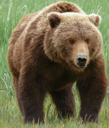

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [ ]:
fns = get_image_files(path)
fns

(#408) [Path('bears/grizzly/00000120.jpg'),Path('bears/grizzly/00000066.JPG'),Path('bears/grizzly/00000003.jpg'),Path('bears/grizzly/00000073.jpg'),Path('bears/grizzly/00000137.jpg'),Path('bears/grizzly/00000017.jpg'),Path('bears/grizzly/00000127.jpg'),Path('bears/grizzly/00000122.jpg'),Path('bears/grizzly/00000034.jpg'),Path('bears/grizzly/00000052.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [ ]:
failed = verify_images(fns)
failed

(#11) [Path('bears/grizzly/00000044.png'),Path('bears/grizzly/00000136.jpeg'),Path('bears/black/00000017.jpg'),Path('bears/black/00000127.jpg'),Path('bears/black/00000032.jpg'),Path('bears/black/00000064.jpg'),Path('bears/teddy/00000085.jpg'),Path('bears/teddy/00000049.jpg'),Path('bears/teddy/00000080.jpg'),Path('bears/teddy/00000063.jpg')...]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
failed.map(Path.unlink);

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

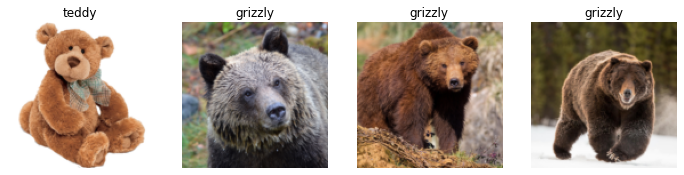

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

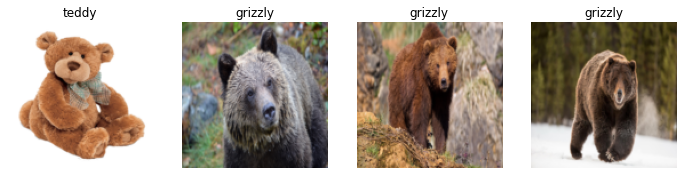

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

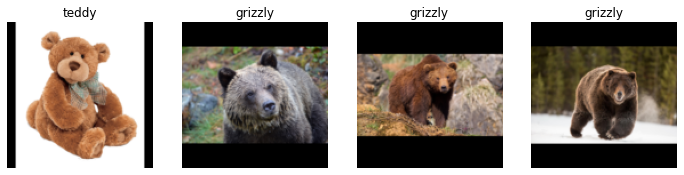

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

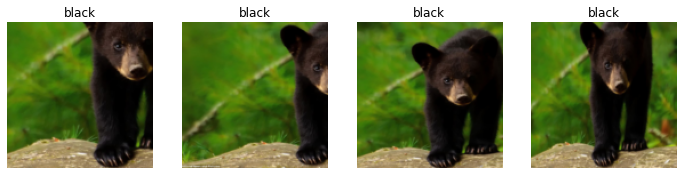

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

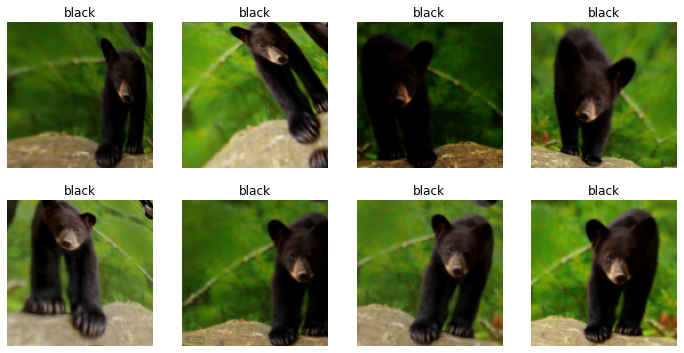

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.389676,0.130019,0.037975,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.245409,0.057629,0.025316,00:18
1,0.172558,0.019302,0.000000,00:18
2,0.126886,0.011629,0.000000,00:18
3,0.099235,0.012903,0.000000,00:18


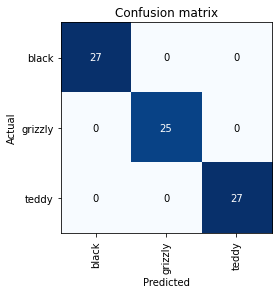

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

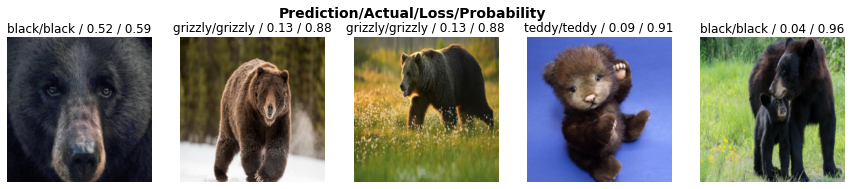

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('drive/MyDrive/images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.1067e-05, 9.9996e-01, 5.7478e-06]))

In [ ]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
# btn_upload = SimpleNamespace(data = ['drive/MyDrive/images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9994')

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 